## Intro to time series analysis using Prophet

Time series are one of the most common data types encountered in daily life. Financial prices, weather, home energy usage, and even weight are all examples of data that can be collected at regular intervals. Almost every data scientist will encounter time series in their daily work and learning how to model them is an important skill in the data science toolbox.

One powerful yet simple method for analyzing and predicting periodic data is the additive model. The idea is straightforward: represent a time-series as a combination of patterns at different scales such as daily, weekly, seasonally, and yearly, along with an overall trend. 
<br>
Example: Your energy use might rise in the summer and decrease in the winter, but have an overall decreasing trend as you increase the energy efficiency of your home. An additive model can show us both patterns/trends and make predictions based on these observations.

I will walk through an introductory example of creating an additive model for financial time-series data using Python and the Prophet forecasting package developed by Facebook. 

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# quandl for financial data
import quandl
# pandas for data manipulation
import pandas as pd
quandl.ApiConfig.api_key = 'YxFnQbyseRwxxdEHhnyd'

## Retrieve Data from Quandl


We will explore the market capitalization of two American car companies, General Motors and Tesla. 
<br>
The dataset was obtained using Quandl financial library. You can make 50 calls to quandl a day with no api key, or create a free account to make unlimited calls per day.
<br>
Quandl automatically puts our data into a pandas dataframe.

In [2]:
# Retrieve TSLA data from Quandl
tesla = quandl.get('WIKI/TSLA')
# Retrieve the GM data from Quandl
gm = quandl.get('WIKI/GM')
gm.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-11-18,35.00,35.99,33.89,34.19,457044300.0,0.0,1.0,29.988317,30.836558,29.037259,29.294302,457044300.0
2010-11-19,34.15,34.50,33.11,34.26,107842000.0,0.0,1.0,29.260029,29.559912,28.368948,29.354278,107842000.0
2010-11-22,34.20,34.48,33.81,34.08,36650600.0,0.0,1.0,29.302870,29.542776,28.968714,29.200053,36650600.0
2010-11-23,33.95,33.99,33.19,33.25,31170200.0,0.0,1.0,29.088668,29.122940,28.437493,28.488901,31170200.0
2010-11-24,33.73,33.80,33.22,33.48,26138000.0,0.0,1.0,28.900170,28.960146,28.463197,28.685967,26138000.0


## Data Exploration

First look at the stock price for two companies.

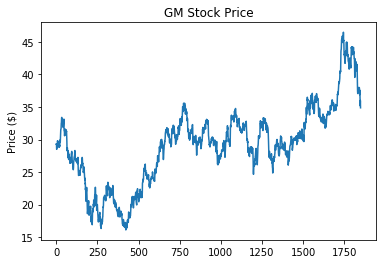

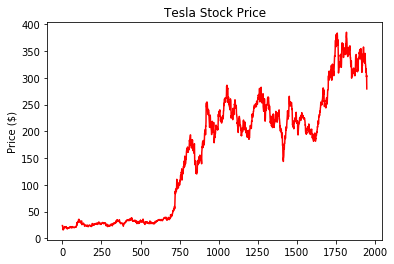

In [48]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(gm.index, gm['Adj. Close'])
plt.title('GM Stock Price')
plt.ylabel('Price ($)')
plt.show()

plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)')
plt.show()

Comparing the two companies on stock prices alone does not show which is more valuable because the total value of a company (market capitalization) also depends on the number of shares (Market cap= share price * number of shares). 
In order to compare the companies, we need to compute their market capitalization. Quandl does not provide this data, but it's not hard to find average yearly stock shares for both companies with a quick Google search. We can figure out the market cap ourselves by multiplying the average number of shares in each year times the share price. 

In [4]:
tesla_shares = {2018: 168e6, 2017: 162e6, 2016: 144e6, 2015: 128e6, 2014: 125e6, 
                2013: 119e6, 2012: 107e6, 2011: 100e6, 2010: 51e6}

gm_shares = {2018: 1.42e9, 2017: 1.50e9, 2016: 1.54e9, 2015: 1.59e9, 2014: 1.61e9, 
                2013: 1.39e9, 2012: 1.57e9, 2011: 1.54e9, 2010: 1.50e9}

### Calculate Market Capitalization

In [5]:
# Create a year column 
tesla['Year'] = tesla.index.year

# Take Dates from index and move to Date column 
tesla.reset_index(level=0, inplace = True)
tesla['cap'] = 0

# Calculate market cap for all years
for i, year in enumerate(tesla['Year']):
    # Retrieve the shares for the year
    shares = tesla_shares.get(year)
    
    # Update the cap column to shares times the price
    tesla.loc[i, 'cap'] = shares * tesla.loc[i, 'Adj. Close']
    
gm['Year'] = gm.index.year

# Take Dates from index and move to Date column 
gm.reset_index(level=0, inplace = True)
gm['cap'] = 0

# Calculate market cap for all years
for i, year in enumerate(gm['Year']):
    # Retrieve the shares for the year
    shares = gm_shares.get(year)
    
    # Update the cap column to shares times the price
    gm.loc[i, 'cap'] = shares * gm.loc[i, 'Adj. Close']

# Merge the two datasets and rename the columns
cars = gm.merge(tesla, how='inner', on='Date')
cars.rename(columns={'cap_x': 'gm_cap', 'cap_y': 'tesla_cap'}, inplace=True)


# Select only the relevant columns
cars = cars.loc[:, ['Date', 'gm_cap', 'tesla_cap']]

# Divide to get market cap in billions of dollars
cars['gm_cap'] = cars['gm_cap'] / 1e9
cars['tesla_cap'] = cars['tesla_cap'] / 1e9

cars.head()

,Date,gm_cap,tesla_cap
0,2010-11-18,43.941453,1.52439
1,2010-11-19,44.031417,1.58049
2,2010-11-22,43.800079,1.70340
3,2010-11-23,42.733352,1.76307
4,2010-11-24,43.028951,1.80897


The market cap is in billions of dollars. We can see General Motors started off with a market cap about 30 times that of Tesla. Do things stay that way over the entire timeline?

### Visual Comparison

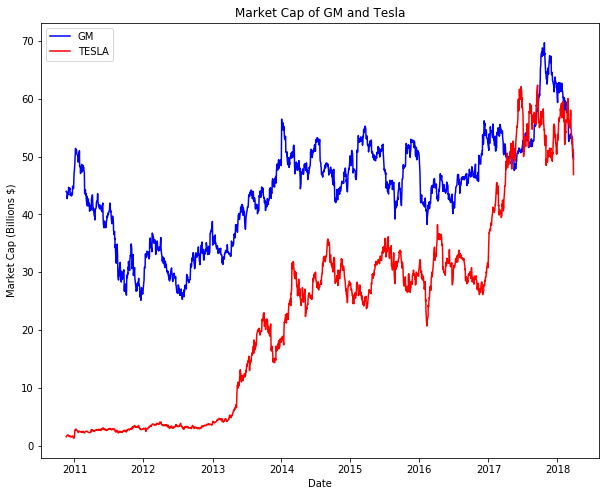

In [7]:
plt.figure(figsize=(10, 8))
plt.plot(cars['Date'], cars['gm_cap'], 'b-', label = 'GM')
plt.plot(cars['Date'], cars['tesla_cap'], 'r-', label = 'TESLA')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Market Cap of GM and Tesla')
plt.legend()

We observe a big rise for Tesla and a minor increase for General Motors over the course of the data. 
<br>
Tesla briefly surpassed GM in market cap in 2017. When did this occur?

In [8]:
# Find the first and last time Tesla was valued higher than GM
first_date = cars.loc[np.min(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']
last_date = cars.loc[np.max(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']

print("Tesla was valued higher than GM from {} to {}.".format(first_date.date(), last_date.date()))

Tesla was valued higher than GM from 2017-04-10 to 2018-03-23.


Although the value of Tesla is now lower than GM, a good question might be, can we expect Tesla to again surpass GM? When will this happen? For that we turn to additive models for forecasting.

## Modeling with FB Prophet 

The Facebook Prophet package was released in 2017 for Python and R. 
<br>
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 
<br>
1). The cool thing about this algorithm is that it is very flexible when it comes to the data that is fed to the algorithm. You can have NAs and don’t need to have all the dates and times lined up.
<br>
2). And, it works pretty reasonably by default, without setting any parameters explicitly. And if you have a domain knowledge then you can configure some of the parameters to improve the model further, but those parameters are pretty straightforward to understand.
<br>
3). Allows for a large number of people to make forecasts, possibly without training in time series methods
<br>
<br>
Prophet, like quandl, can be installed with pip from the command line.
<br>
<br>
We first import prophet and rename the columns in our data to the correct format. The Date column must be called ‘ds’ and the value column we want to predict ‘y’. We then create prophet models and fit them to the data, much like a Scikit-Learn model

In [51]:
import fbprophet
# Prophet requires columns ds (Date) and y (value)
gm = gm.rename(columns={'Date': 'ds', 'cap': 'y'})
# Put market cap in billions
gm['y'] = gm['y'] / 1e9

# Make the prophet models and fit on the data
# changepoint_prior_scale can be changed to achieve a better fit
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15, daily_seasonality=True)
gm_prophet.fit(gm)

# Repeat for the tesla data
tesla =tesla.rename(columns={'Date': 'ds', 'cap': 'y'})
tesla['y'] = tesla['y'] / 1e9
tesla_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15, n_changepoints=10, daily_seasonality=True)
tesla_prophet.fit(tesla)

When creating the prophet models, I set the changepoint prior to 0.15(the default value is 0.05). This hyperparameter is used to control how sensitive the trend is to changes, with a higher value being more sensitive and a lower value less sensitive. This value is used to deal with bias vs. variance.
<br>
When a model is underfitting, increasing the changepoint prior allows more flexibility for the model to fit the data, and if the model is overfitting, decreasing the prior limits the amount of flexibility. The effect of the changepoint prior scale can be illustrated by the next plot.

In [53]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(tesla)
    
    future = model.make_future_dataframe(periods=365, freq='D')
    future = model.predict(future)
    
    tesla[changepoint] = future['yhat']

Text(0.5, 1.0, 'Effect of Changepoint Prior Scale')

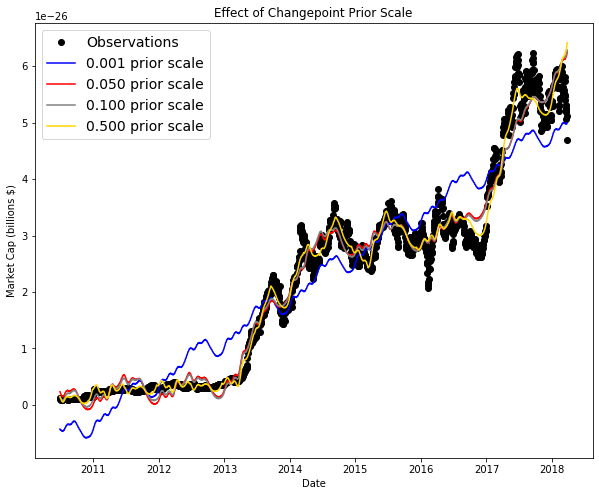

In [54]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(tesla['ds'], tesla['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(tesla['ds'], tesla[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)'); plt.title('Effect of Changepoint Prior Scale')

### Predictions for 3 Years

To make forecasts, we need to create what is called a future dataframe. We specify the number of future periods to predict (3 years) and the frequency of predictions (daily). We then make predictions with the prophet model we created and the future dataframe.
<br>
Our future dataframes contain the estimated market cap of Tesla and GM for the next 3 years. We can visualize predictions with the prophet plot function.

In [52]:
# Make a future dataframe for 3 years
gm_forecast = gm_prophet.make_future_dataframe(periods=365 * 3, freq='D')
# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

tesla_forecast = tesla_prophet.make_future_dataframe(periods=365*3, freq='D')
tesla_forecast = tesla_prophet.predict(tesla_forecast)

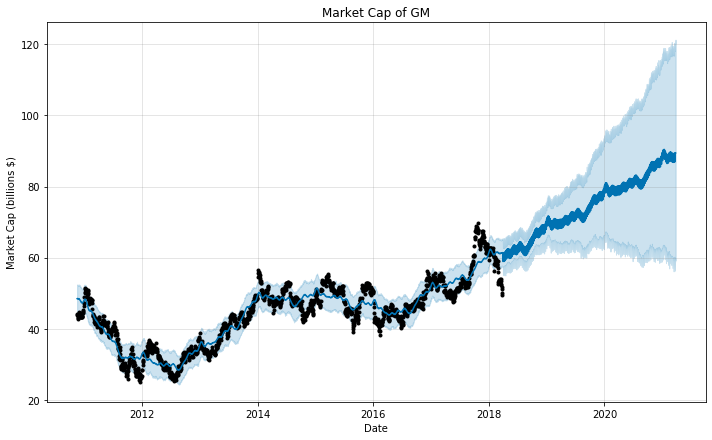

In [17]:
gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of GM');

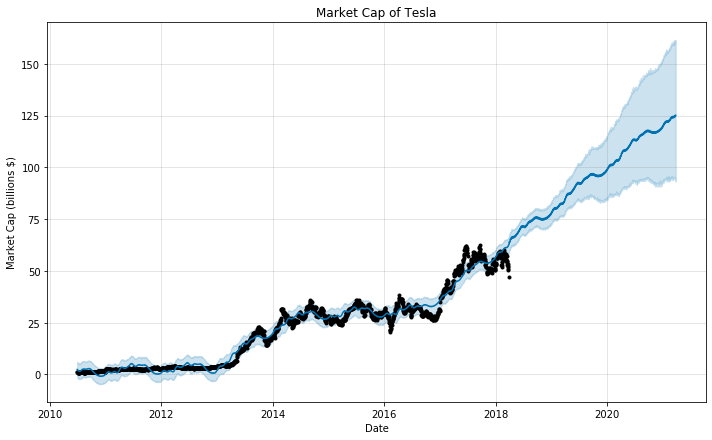

In [18]:
tesla_prophet.plot(tesla_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Tesla');

The black dots represent the actual values, the blue line indicates the forecasted values, and the light blue shaded region is the uncertainty. The region of uncertainty increases as time goes by because initial uncertainty propagates and grows over time. 

We can also inspect changepoints identified by the model. Changepoints represent when the time series growth rate significantly changes (goes from increasing to decreasing for example). 
<br>
Notice: Changepoints can correspond to significant events such as product launches or macroeconomic swings in the market. If we do not specify changepoints, prophet will calculate them for us.

In [57]:
gm_prophet.changepoints[:10]

59    2011-02-14
118   2011-05-10
177   2011-08-03
236   2011-10-26
296   2012-01-24
355   2012-04-18
414   2012-07-12
473   2012-10-04
532   2013-01-02
591   2013-03-28
Name: ds, dtype: datetime64[ns]

In [58]:
tesla_prophet.changepoints[:10]

156    2011-02-09
312    2011-09-22
467    2012-05-04
623    2012-12-18
779    2013-08-02
935    2014-03-18
1091   2014-10-28
1246   2015-06-11
1402   2016-01-25
1558   2016-09-06
Name: ds, dtype: datetime64[ns]

### Compare Forecasts

We want to determine when Tesla will overtake GM in total market value. We already have the forecasts for 3 years into the future. We will now join them together and determine when the model predicts Tesla will surpass GM.

In [25]:
gm_names = ['gm_%s' % column for column in gm_forecast.columns]
tesla_names = ['tesla_%s' % column for column in tesla_forecast.columns]

# Dataframes to merge
merge_gm_forecast = gm_forecast.copy()
merge_tesla_forecast = tesla_forecast.copy()

# Rename the columns
merge_gm_forecast.columns = gm_names
merge_tesla_forecast.columns = tesla_names

In [26]:
# Merge the two datasets
forecast = pd.merge(merge_gm_forecast, merge_tesla_forecast, how = 'inner', left_on = 'gm_ds', right_on = 'tesla_ds')

# Rename date column
forecast = forecast.rename(columns={'gm_ds': 'Date'}).drop('tesla_ds', axis=1)
forecast.head()

,Date,gm_trend,gm_yhat_lower,gm_yhat_upper,gm_trend_lower,gm_trend_upper,gm_additive_terms,gm_additive_terms_lower,gm_additive_terms_upper,gm_weekly,...,tesla_weekly,tesla_weekly_lower,tesla_weekly_upper,tesla_yearly,tesla_yearly_lower,tesla_yearly_upper,tesla_multiplicative_terms,tesla_multiplicative_terms_lower,tesla_multiplicative_terms_upper,tesla_yhat
0,2010-11-18,47.143796,44.776983,52.467906,47.143796,47.143796,1.334752,1.334752,1.334752,0.734087,...,-0.192466,-0.192466,-0.192466,-2.284715,-2.284715,-2.284715,0.0,0.0,0.0,-0.693293
1,2010-11-19,47.102021,44.946671,52.407803,47.102021,47.102021,1.312172,1.312172,1.312172,0.674446,...,-0.221076,-0.221076,-0.221076,-2.318645,-2.318645,-2.318645,0.0,0.0,0.0,-0.745844
2,2010-11-22,46.976698,44.706504,52.459191,46.976698,46.976698,1.469148,1.469148,1.469148,0.696183,...,-0.137378,-0.137378,-0.137378,-2.409908,-2.409908,-2.409908,0.0,0.0,0.0,-0.723438
3,2010-11-23,46.934923,44.556000,52.168879,46.934923,46.934923,1.477682,1.477682,1.477682,0.656102,...,-0.171823,-0.171823,-0.171823,-2.436556,-2.436556,-2.436556,0.0,0.0,0.0,-0.774541
4,2010-11-24,46.893149,44.801150,52.205885,46.893149,46.893149,1.601959,1.601959,1.601959,0.732381,...,-0.128724,-0.128724,-0.128724,-2.461211,-2.461211,-2.461211,0.0,0.0,0.0,-0.746107


### Visualize Trend Only and the Forecast

Text(0.5, 1.0, 'GM vs. Tesla Trend')

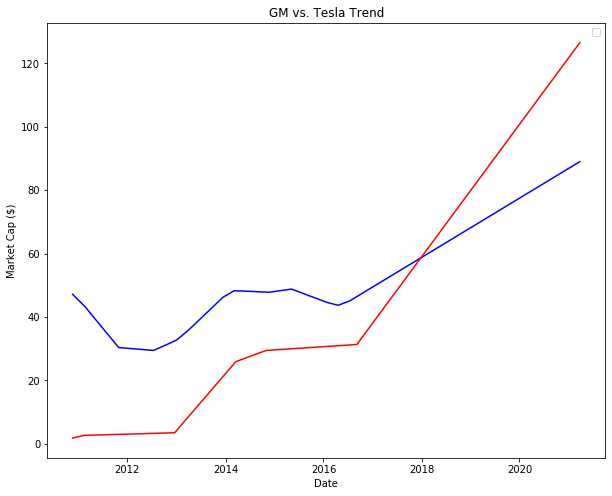

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_trend'], 'b-')
plt.plot(forecast['Date'], forecast['tesla_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Market Cap ($)')
plt.title('GM vs. Tesla Trend')

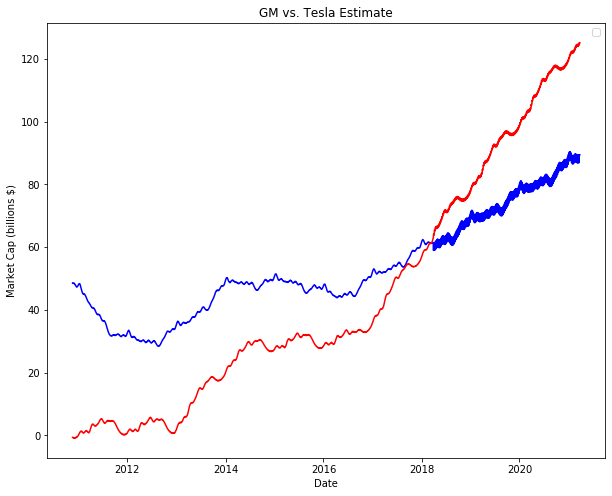

In [28]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['tesla_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)')
plt.title('GM vs. Tesla Estimate');

This is plotting the estimate (called ‘yhat’ in the prophet package). It smooths out some of the noise in the data so it looks a little different than the raw plots.

In [30]:
overtake_date = min(forecast.loc[forecast['tesla_yhat'] > forecast['gm_yhat'], 'Date'])
print('Tesla overtakes GM on {}'.format(overtake_date))

Tesla overtakes GM on 2018-03-05 00:00:00


### Forecast with Uncertainty Bounds

We can also use matplotlib to show the regions of uncertainty.

In [31]:
# Only keep years 2011 onwards and from before 2020
forecast = forecast[forecast['Date'] > '2010-12-31']
forecast = forecast[forecast['Date'] < '2020-01-01']

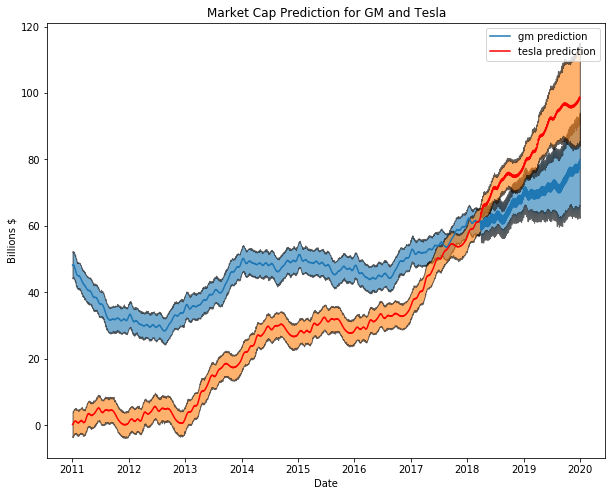

In [32]:
# Create subplots to set figure size
fig, ax = plt.subplots(1, 1, figsize=(10, 8));

# Plot estimate
ax.plot(forecast['Date'], forecast['gm_yhat'], label = 'gm prediction');

# Plot uncertainty values
ax.fill_between(forecast['Date'].dt.to_pydatetime(), forecast['gm_yhat_upper'], forecast['gm_yhat_lower'], alpha=0.6, edgecolor = 'k');

# Plot estimate and uncertainty for tesla
ax.plot(forecast['Date'], forecast['tesla_yhat'], 'r', label = 'tesla prediction');
ax.fill_between(forecast['Date'].dt.to_pydatetime(), forecast['tesla_yhat_upper'], forecast['tesla_yhat_lower'], alpha=0.6, edgecolor = 'k');
plt.legend();
plt.xlabel('Date'); plt.ylabel('Billions $'); plt.title('Market Cap Prediction for GM and Tesla');

This plot shows the value of both companies is expected to increase, but Tesla will increase more rapidly than General Motors.The uncertainty increases over time as expected for a prediction and the lower bound of Tesla is below the upper bound of GM in 2020, meaning GM might retain the lead.

### Trends and Patterns

Now, we can use the Prophet Models to inspect different trends in the data. 
<br>
Prophet allows us to easily visualize the overall trend and the component patterns

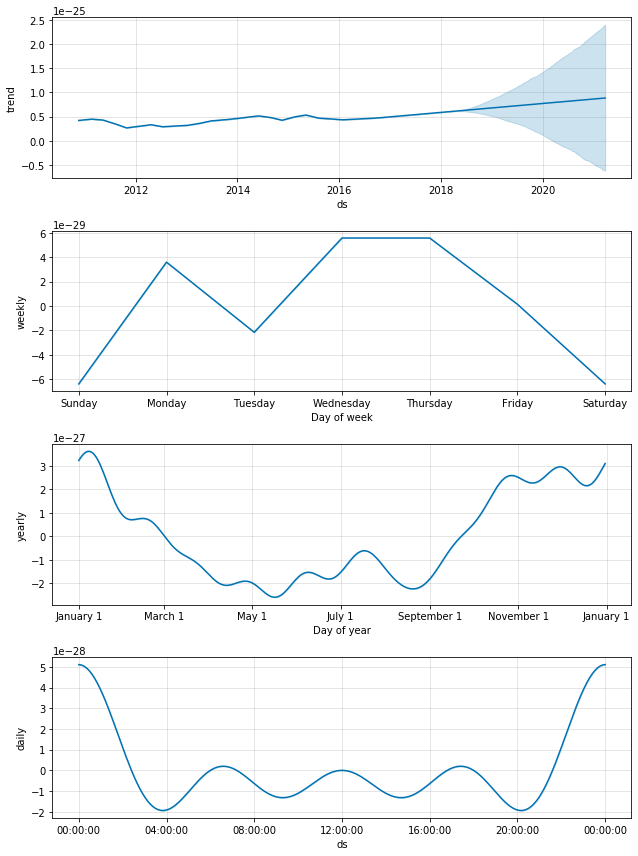

In [59]:
gm_prophet.plot_components(gm_forecast);

The yearly pattern suggests GM increases in value at the end of the year, and there is a long slow decline into the summer. We can try to determine if there is a correlation between the yearly market cap and the average monthly sales of GM over the time period. 
<br>
I gathered the monthly vehicle sales from Google

In [38]:
# Read in the sales data
gm_sales = pd.read_csv('gm_sales.csv')
gm_sales.head(5)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
0,2017,195909,237388,256224,244406,237364,243151,226107,275552,279397,252813,245387,308539,3002237
1,2016,203745,227825,252128,259557,240449,255209,267258,256429,249795,258626,252644,319108,3042773
2,2015,202786,231378,249875,269055,293097,259346,272512,270480,251310,262993,229296,290230,3082358
3,2014,171486,222104,256047,254076,284694,267461,256160,272422,223437,226819,225818,274483,2935007
4,2013,194699,224314,245950,237646,252894,264843,234071,275847,187195,226402,212060,230157,2786078


In [39]:
# Melt the sales data and rename columns
gm_sales = gm_sales.melt(id_vars='Year', var_name = 'Month', value_name = 'Sales')
gm_sales.head(8)

,Year,Month,Sales
0,2017,Jan,195909
1,2016,Jan,203745
2,2015,Jan,202786
3,2014,Jan,171486
4,2013,Jan,194699
5,2012,Jan,167962
6,2011,Jan,178896
7,2010,Jan,145098


Text(0.5, 1.0, 'GM Average Monthly Sales 2011-2017')

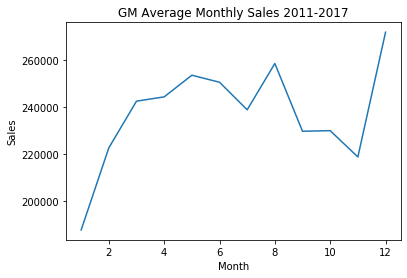

In [41]:
gm_sales_grouped = gm_sales.groupby('Month').mean()
plt.plot(list(range(1, 13)), gm_sales_grouped['Sales']);
plt.xlabel('Month'); plt.ylabel('Sales'); plt.title('GM Average Monthly Sales 2011-2017')

It does not look like monthly sales are correlated with the market cap. The monthly sales are second highest in August, which is right at the lowest point for the market cap